## Audio Masked Autoencoders

This is a demo loading pre-trained MAE models. No GPU is needed.

In [4]:
!pip3 install nbconvert

In [3]:
!pip install pyppeteer

In [1]:
!pip3 install nbconvert[webpdf]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 121.9 kB/s eta 0:00:0036m0:00:01
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached importlib_metadata-6.8.0-py3-none-any.whl (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 1.0 MB/s eta 0:00:00 MB/s eta 0:00:01


In [19]:
!pip3 install torch torchvision torchaudio

In [2]:
!pip install  timm==0.3.2

In [31]:
import sys
import os
import requests
import torchaudio
from torchaudio.compliance import kaldi
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
sys.path.append("../")
import models_aud_mae

### Define utils

In [32]:
# define the utils
def prepare_model(chkpt_dir, arch='mae_vit_base_patch16', decode=1):
    # build model
    model = getattr(models_aud_mae, arch)(in_chans=1, audio_exp=True,img_size=(1024,128), decoder_mode=decode)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model


In [33]:
MELBINS=128
TARGET_LEN=1024
def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False, 
                        window_type='hanning', num_mel_bins=MELBINS, dither=0.0, frame_shift=10)
    # AudioSet: 1024 (16K sr)
    # ESC: 512 (8K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank

In [34]:
def display_fbank(bank, minmin=None, maxmax=None):
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')

Cage c4 - May 10th

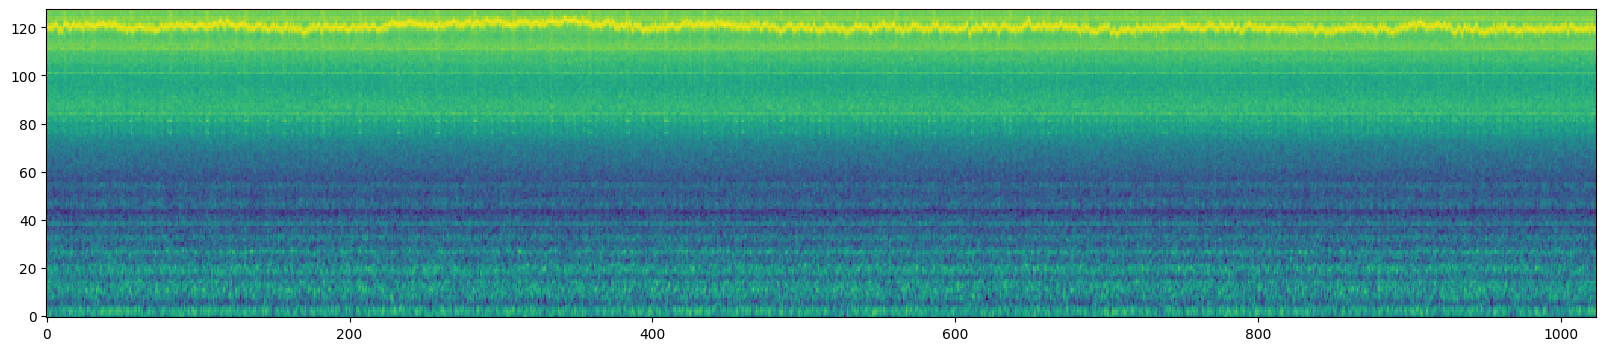

In [35]:
wav_file = '/home/adelina/projectMae/multimodal-mae-main/audio_files/dvc-backboard@10.05.2023_00.05.14Z_10.05.2023_00.20.15Z@3d0025-jVST6ZCWr5ixPffUUUKVZm.wav'
fbank = wav2fbank(wav_file)
fbank = norm_fbank(fbank)
display_fbank(fbank)

In [36]:
%reload_ext autoreload
%autoreload 2

In [37]:
chkpt_dir = '/home/adelina/Downloads/AudioMAE/pretrained.pth'
model = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [38]:
x = torch.tensor(fbank)
print(x.shape)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = x.unsqueeze(dim=0)
print(x.shape)

torch.Size([1024, 128])
torch.Size([1, 1, 1024, 128])


/tmp/ipykernel_561028/959757395.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


In [39]:
# run MAE
loss, y, mask,_ = model(x.float(), mask_ratio=0.1)
print('y_shape:',y.shape, mask.shape)
y = model.unpatchify(y)
y = torch.einsum('nchw->nhwc', y).detach().cpu()



y_shape: torch.Size([1, 512, 256]) torch.Size([1, 512])


# Visualization of Mask
These are taken from the AudioMAE Repo

In [40]:
# visualize the mask
mask = mask.detach()
#mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)
print(mask.shape)
mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

x = torch.einsum('nchw->nhwc', x)

# masked image
im_masked = x * (1 - mask) 

# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask




torch.Size([1, 512, 256])


In [41]:
minmin = np.min([x[0].min(), im_masked[0].min(), y[0].min(), im_paste[0].min()])
maxmax = np.max([x[0].max(), im_masked[0].max(), y[0].max(), im_paste[0].max()])
minmin *= 10
maxmax *= 1
minmin=-10
maxmax=10
start=300
end=900
print(minmin,maxmax)

-10 10


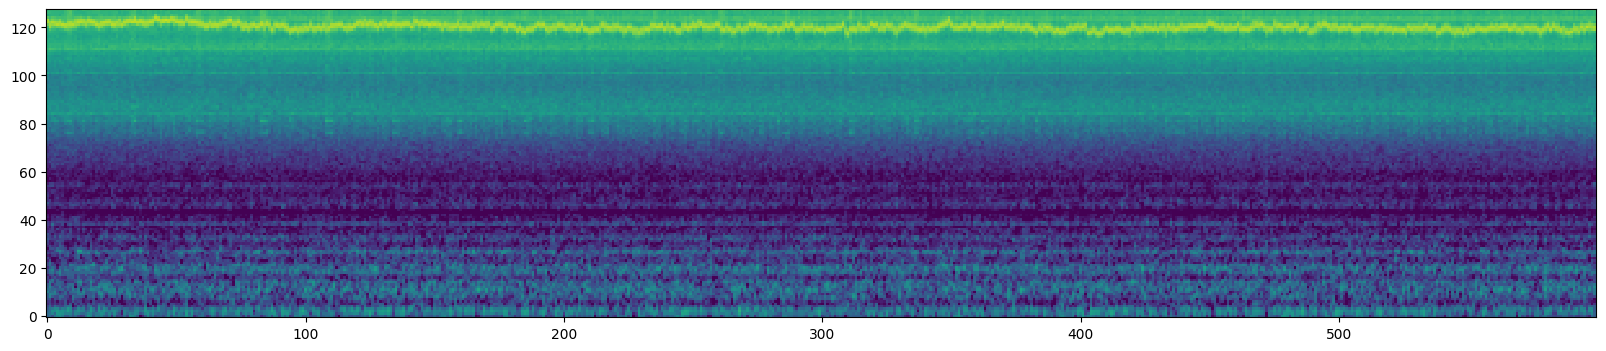

In [42]:
display_fbank(x[0][start:end].squeeze(), minmin=minmin, maxmax=maxmax)

In [43]:
im_masked2 = im_masked + (mask)*-10

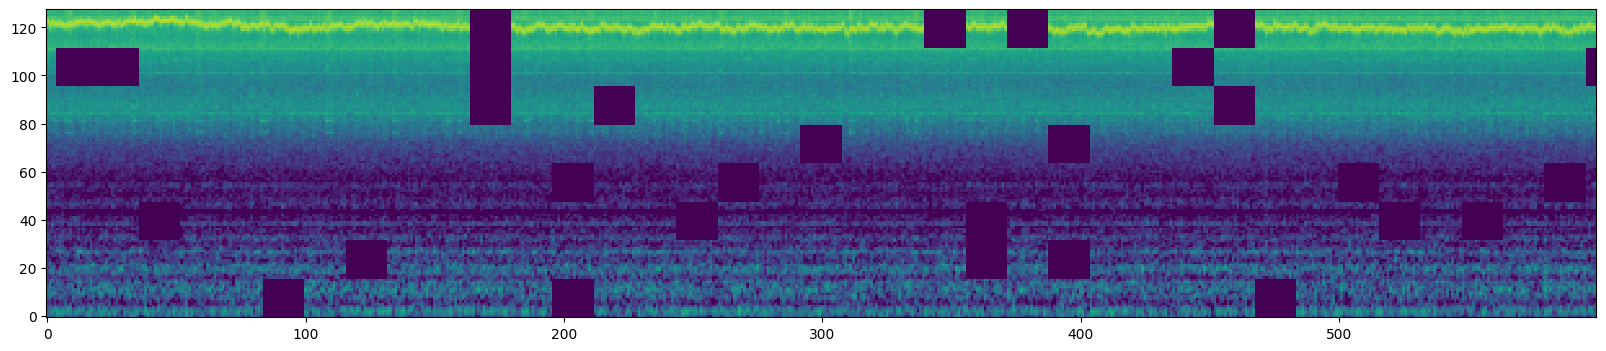

In [44]:
display_fbank(im_masked2[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

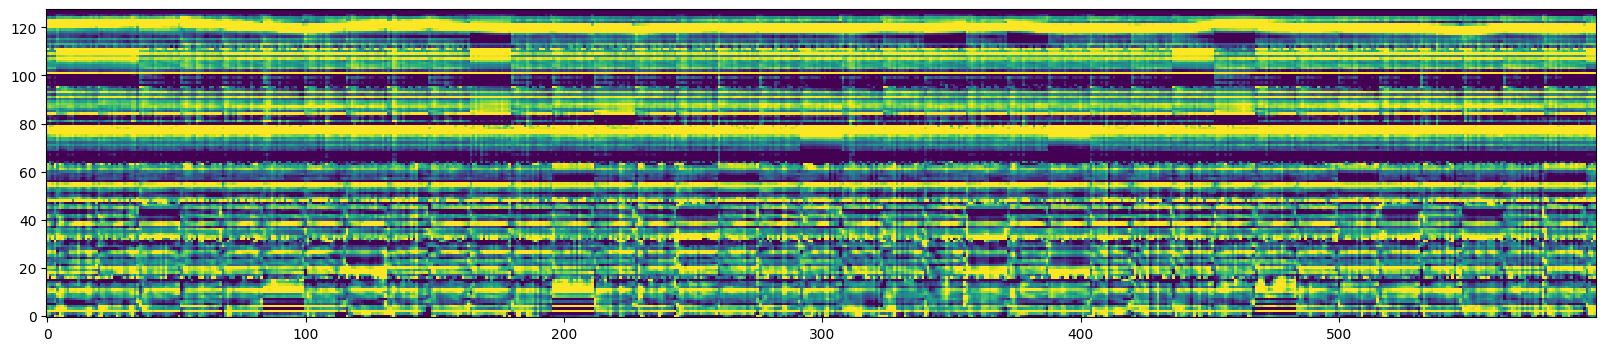

In [45]:
display_fbank((y[0][start:end]).squeeze(), minmin=minmin, maxmax=maxmax)

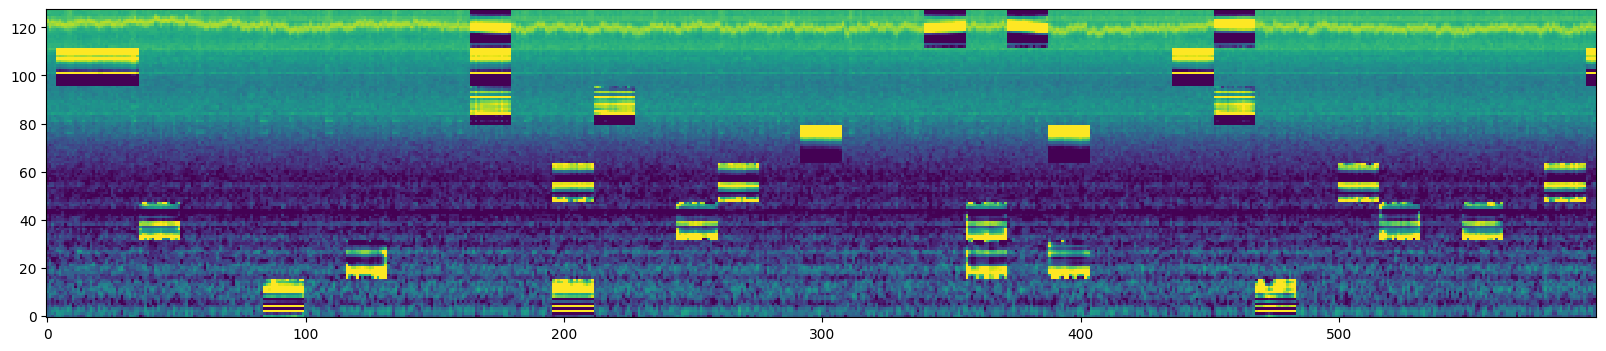

In [46]:
display_fbank(im_paste[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

In [47]:
# MAE reconstruction pasted with visible patches
im_paste = x * (1 - mask) + y * mask

In [48]:
#display_fbank((y * mask - 999).squeeze())

Following the pipeline for other audiofiles and identifying the patterns in spectograms

Other 

In [60]:
def create_spec(name):    
    wav_file = name
    fbank = wav2fbank(wav_file)
    fbank = norm_fbank(fbank)
    display_fbank(fbank)

    x = torch.tensor(fbank)
    #print(x.shape)
    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = x.unsqueeze(dim=0)
    #print(x.shape)
    # run MAE
    loss, y, mask,_ = model(x.float(), mask_ratio=0.1)
    #print('y_shape:',y.shape, mask.shape)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    #mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)
    print(mask.shape)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask) 

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    minmin = np.min([x[0].min(), im_masked[0].min(), y[0].min(), im_paste[0].min()])
    maxmax = np.max([x[0].max(), im_masked[0].max(), y[0].max(), im_paste[0].max()])
    minmin *= 10
    maxmax *= 1
    minmin=-10
    maxmax=10
    start=300
    end=900
    #print(minmin,maxmax)

    display_fbank(x[0][start:end].squeeze(), minmin=minmin, maxmax=maxmax)
    im_masked2 = im_masked + (mask)*-10
    display_fbank(im_masked2[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)
    display_fbank((y[0][start:end]).squeeze(), minmin=minmin, maxmax=maxmax)
    display_fbank(im_paste[0][start:end].squeeze(),minmin=minmin, maxmax=maxmax)

Cage c4, april 21

/tmp/ipykernel_561028/2852888603.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


torch.Size([1, 512, 256])


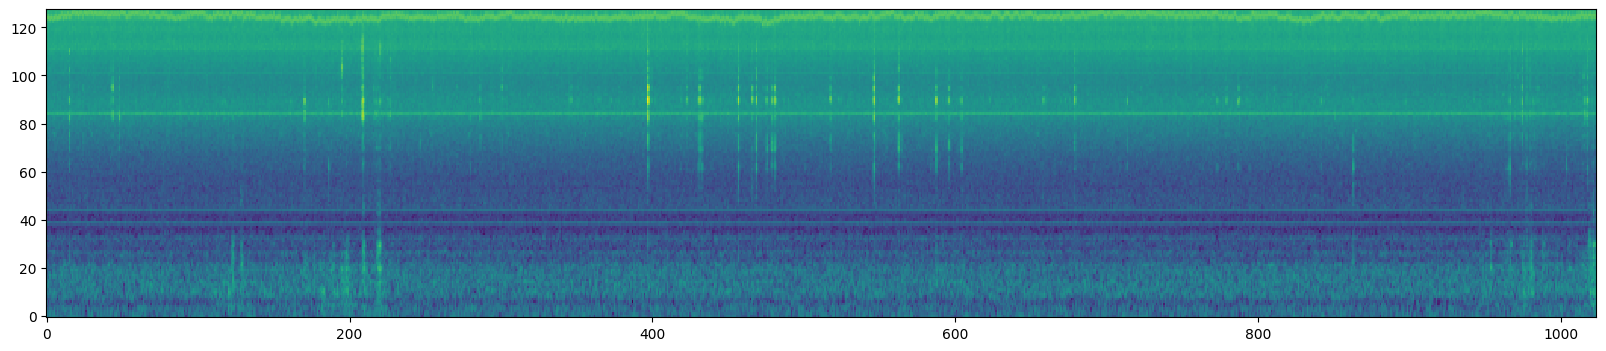

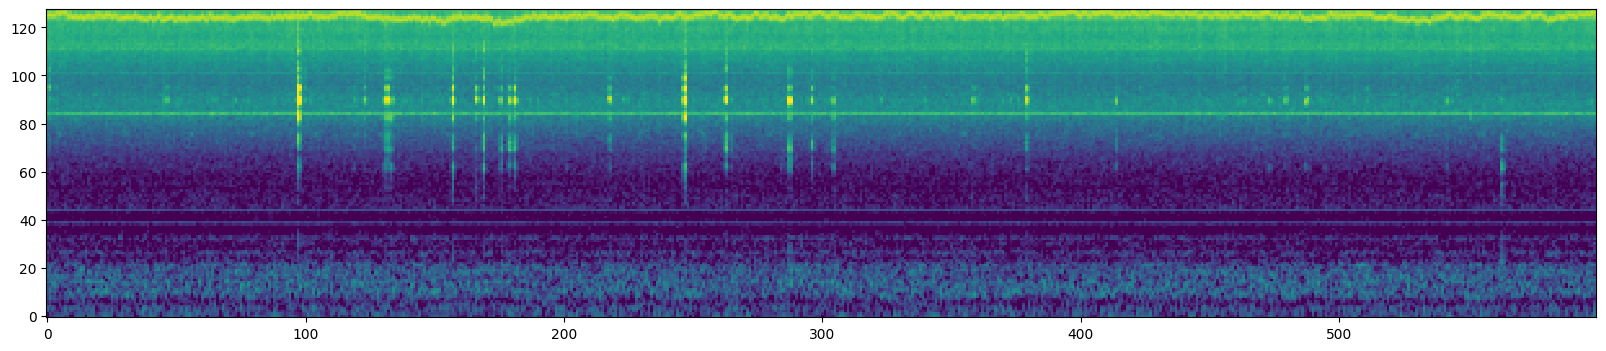

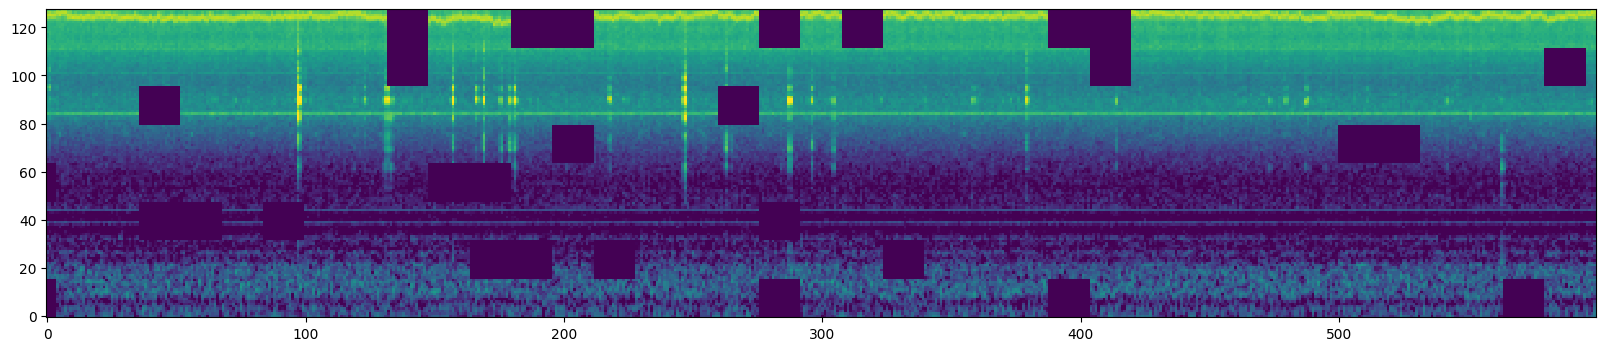

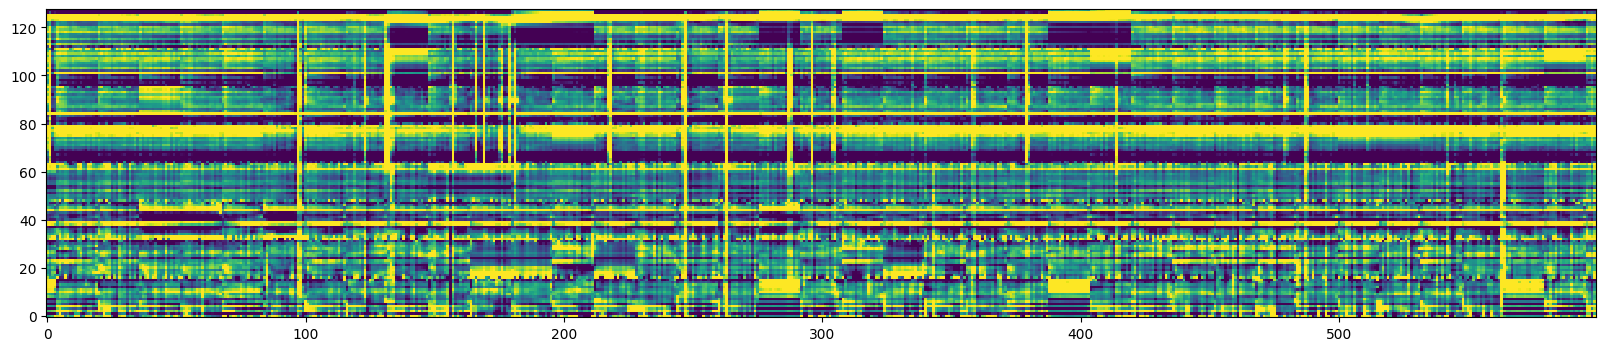

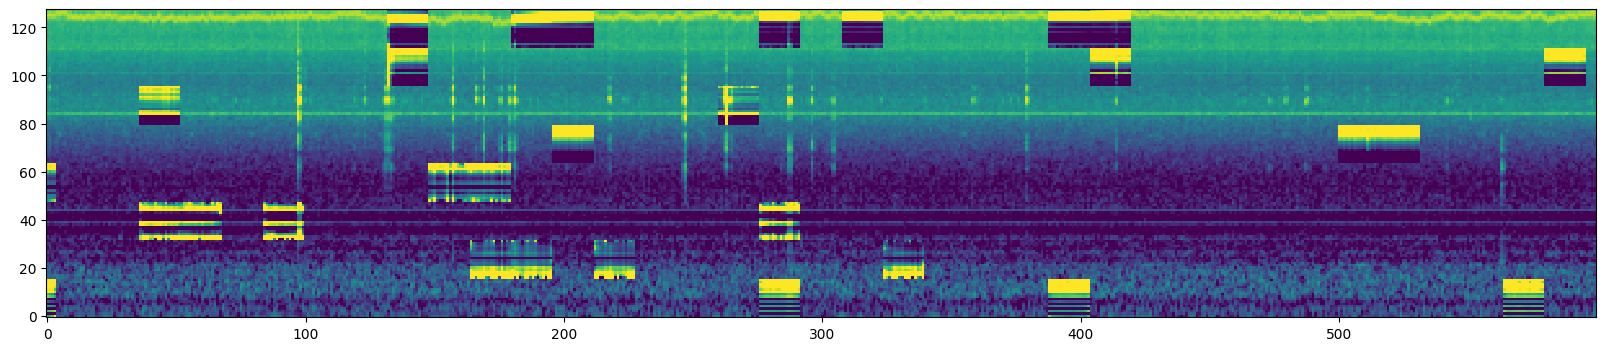

In [61]:
create_spec('/home/adelina/projectMae/multimodal-mae-main/audio_files/dvc-backboard@21.04.2023_00.14.18Z_21.04.2023_00.29.18Z@3d0023-LywVy4QwoYhac3ih3kVv5n.wav')

Cage c4, 29 june

/tmp/ipykernel_561028/2852888603.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


torch.Size([1, 512, 256])


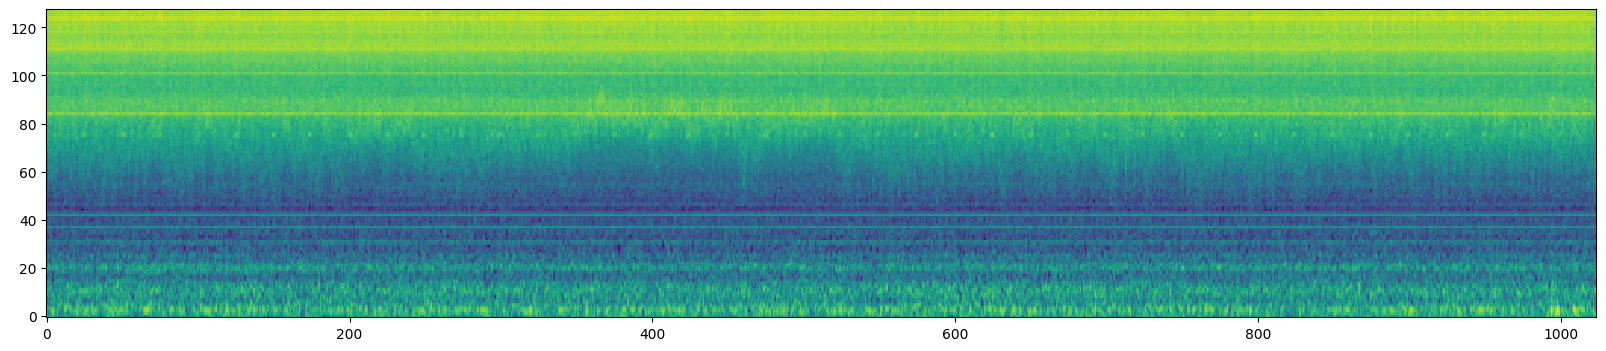

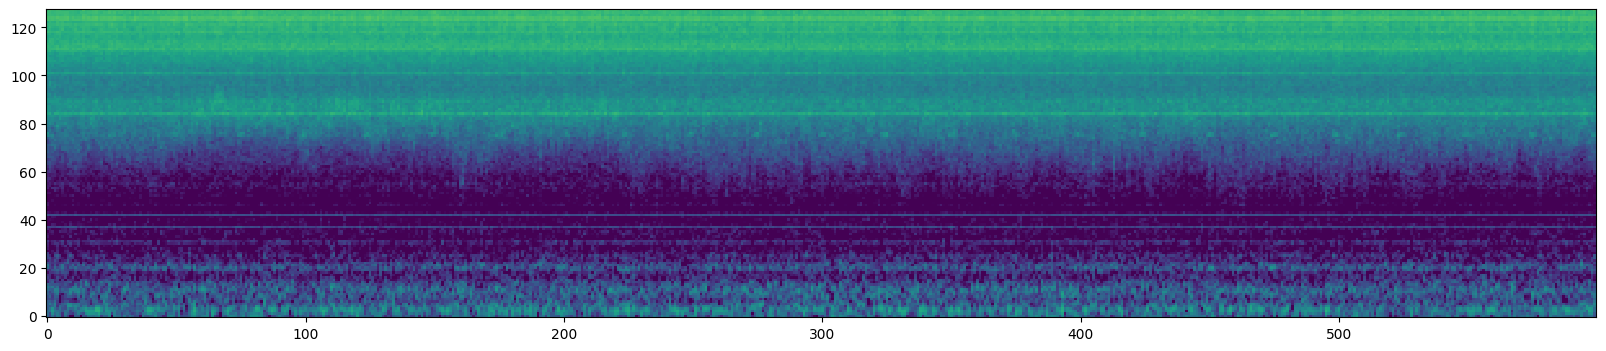

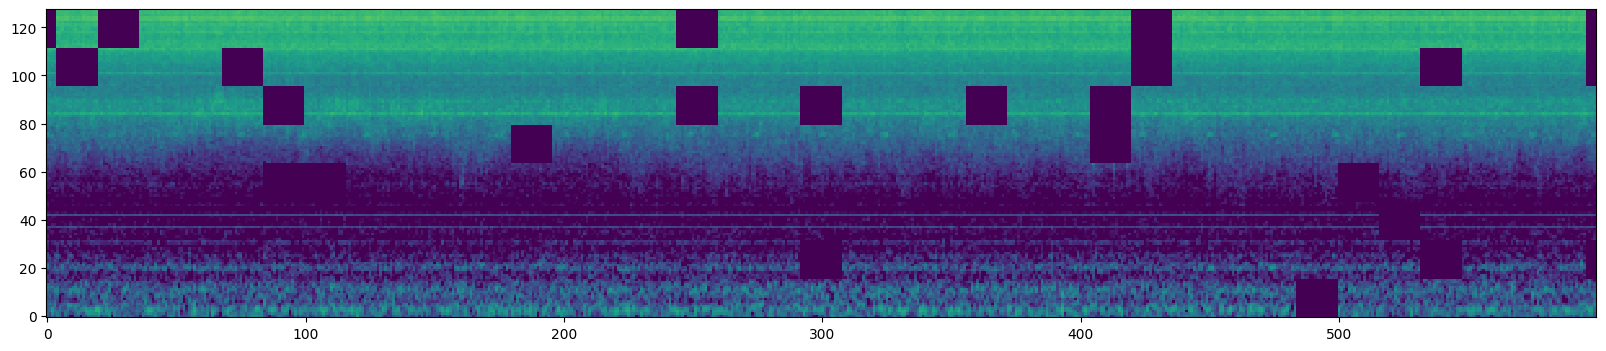

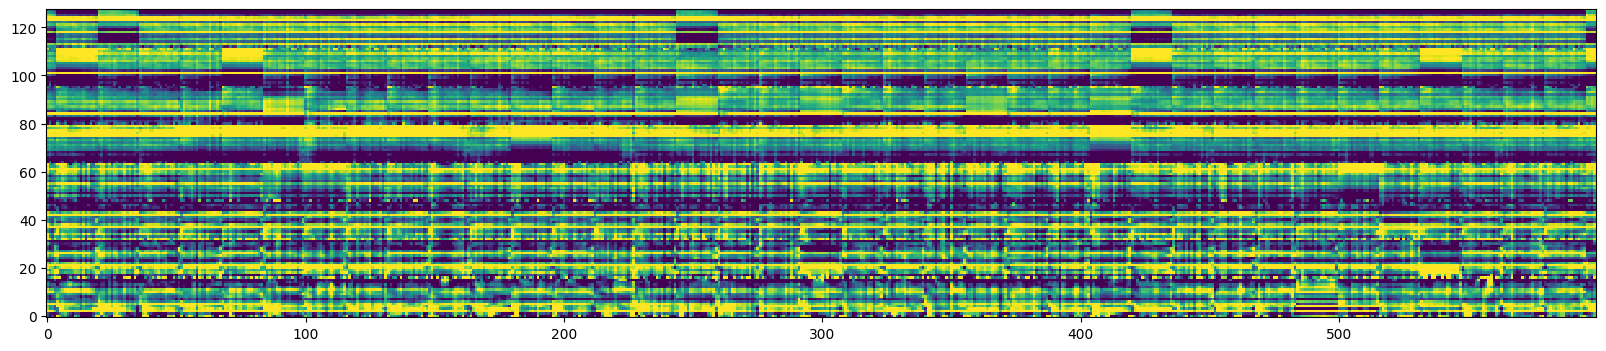

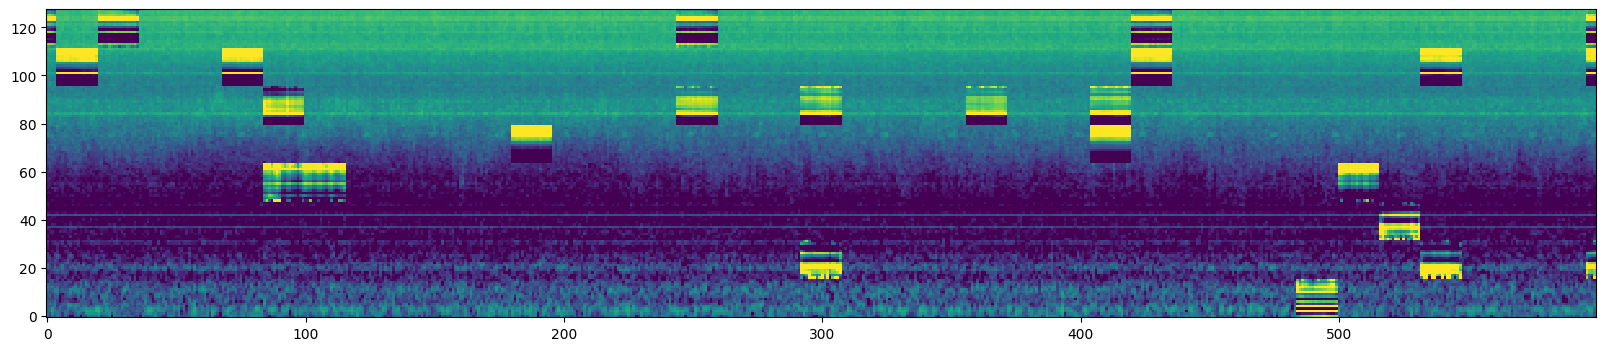

In [62]:
create_spec('/home/adelina/projectMae/multimodal-mae-main/audio_files/dvc-backboard@29.06.2023_01.26.49Z_29.06.2023_01.41.49Z@3d0035-j6iD6Hv8rQEHT3gMXidHy3.wav')

Cage b4, 29 june

/tmp/ipykernel_561028/2852888603.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


torch.Size([1, 512, 256])


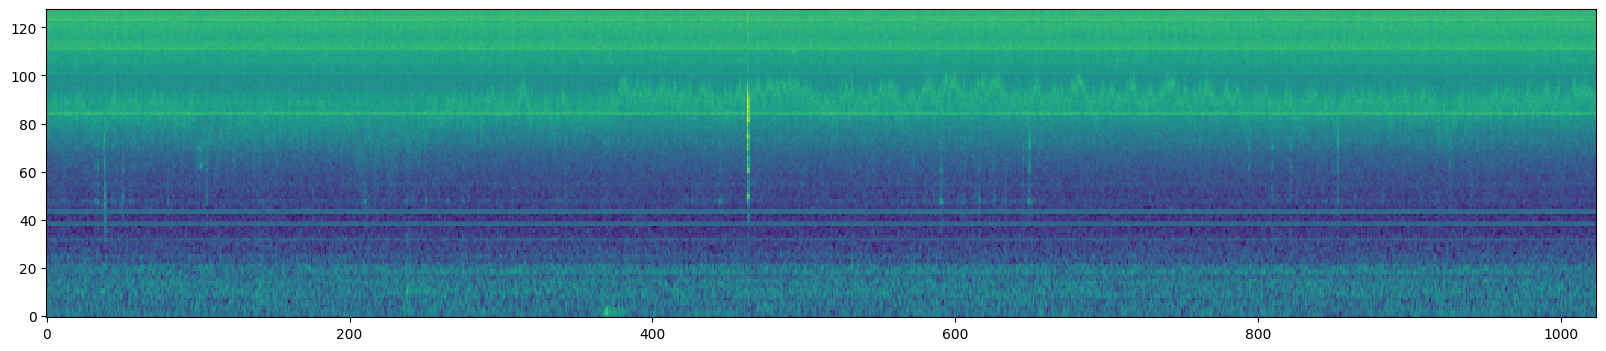

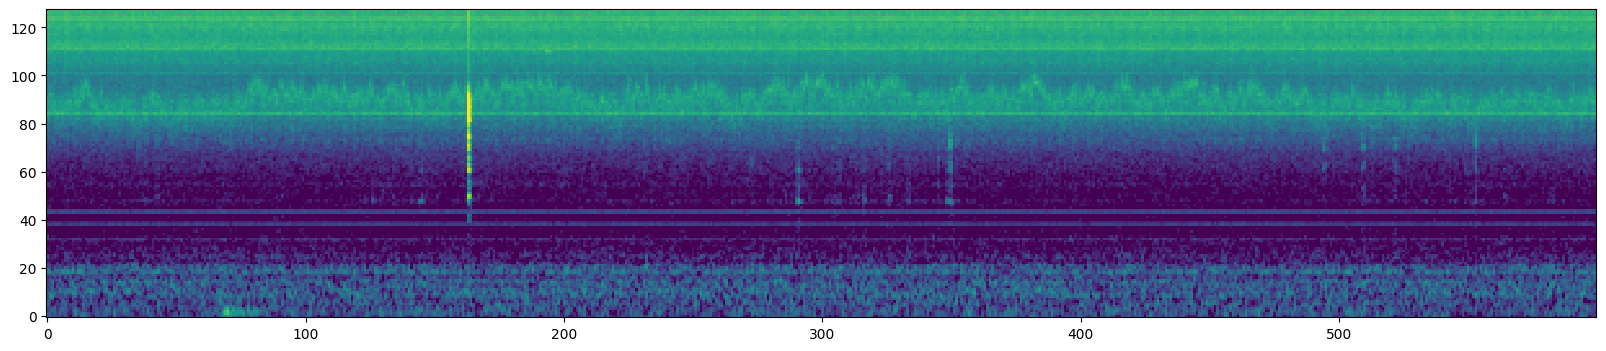

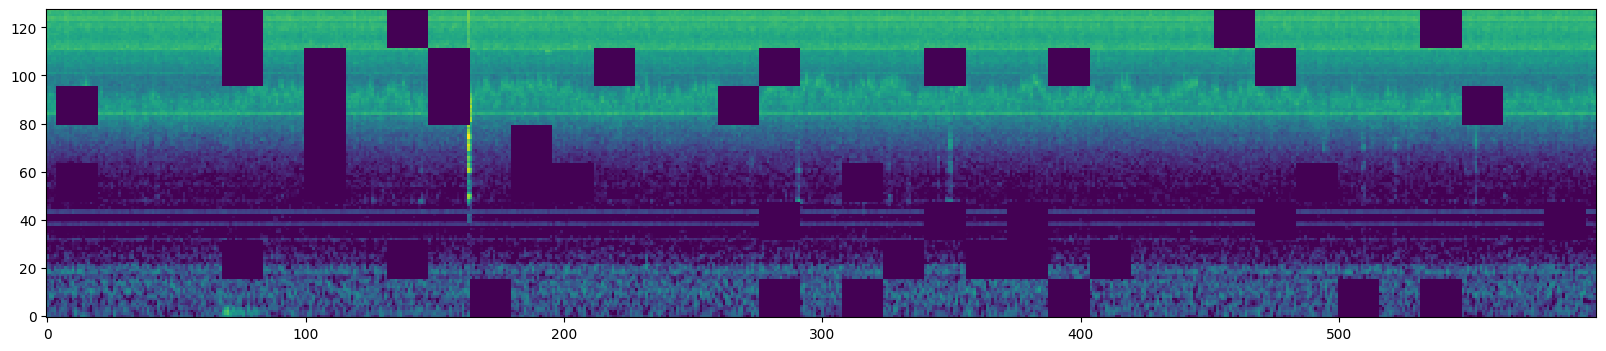

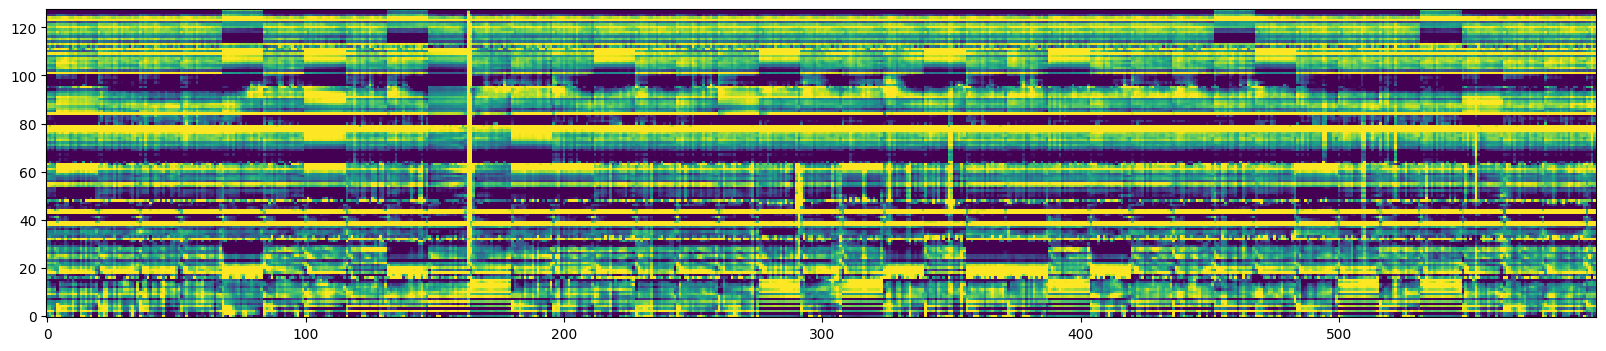

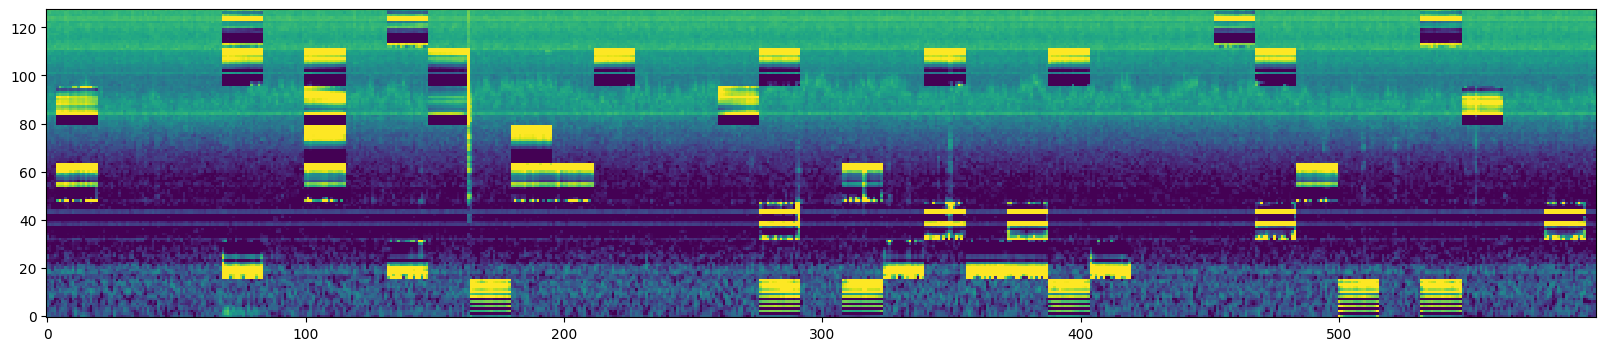

In [63]:
create_spec('/home/adelina/projectMae/multimodal-mae-main/audio_files/dvc-backboard@29.06.2023_01.26.49Z_29.06.2023_01.41.49Z@3d0028-wsvsU5ZqPpmzN8XYARs5qE.wav')

30 June, cage b4

/tmp/ipykernel_561028/2852888603.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


torch.Size([1, 512, 256])


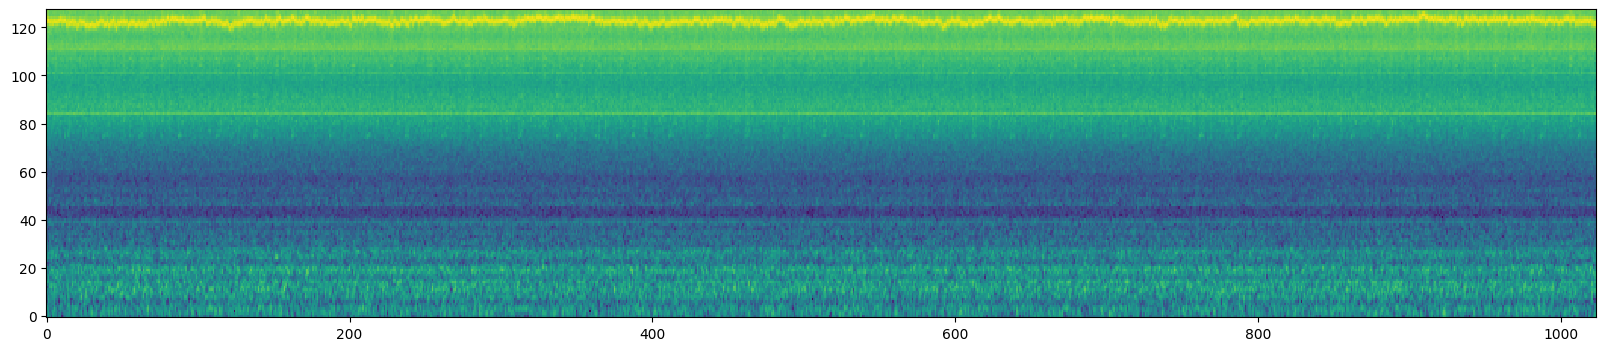

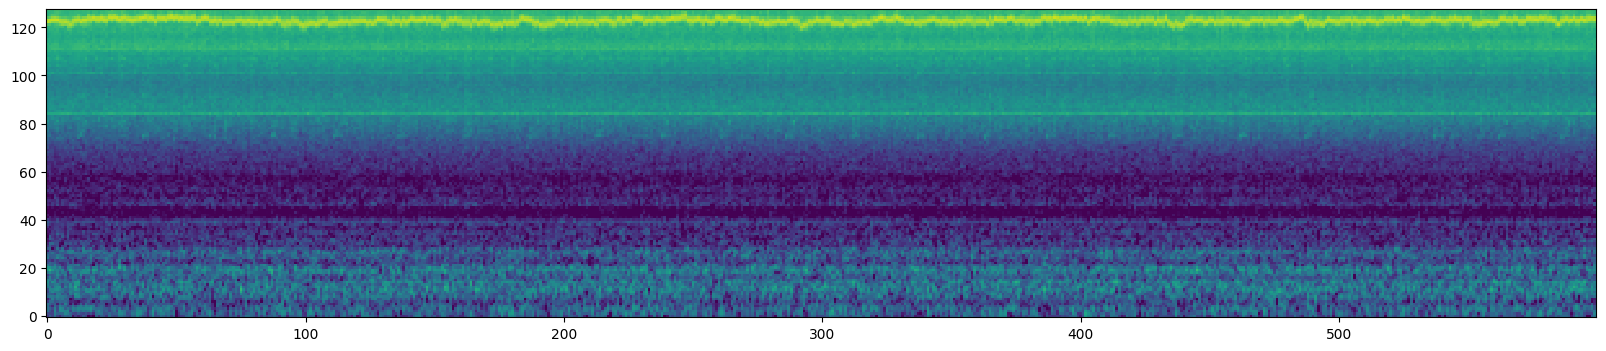

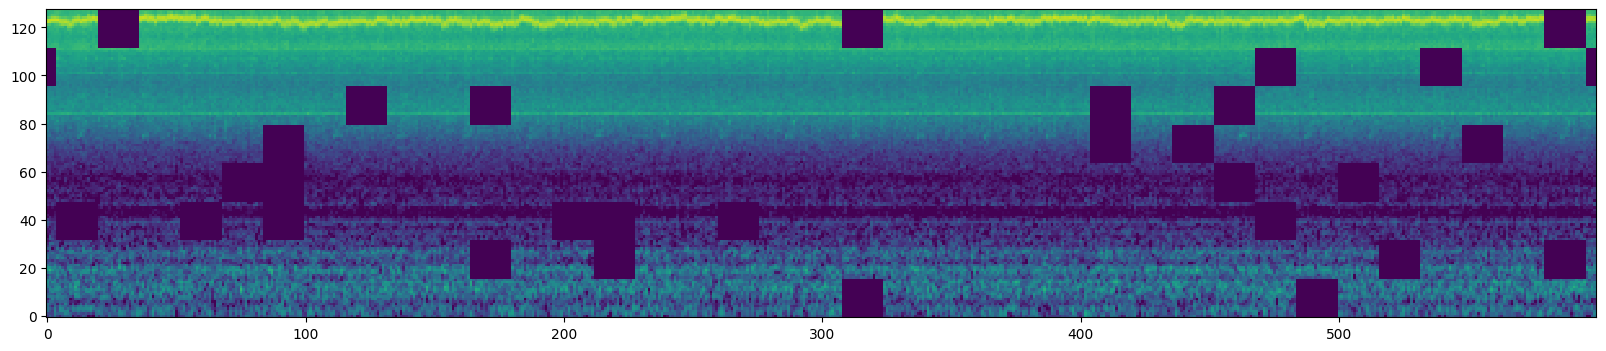

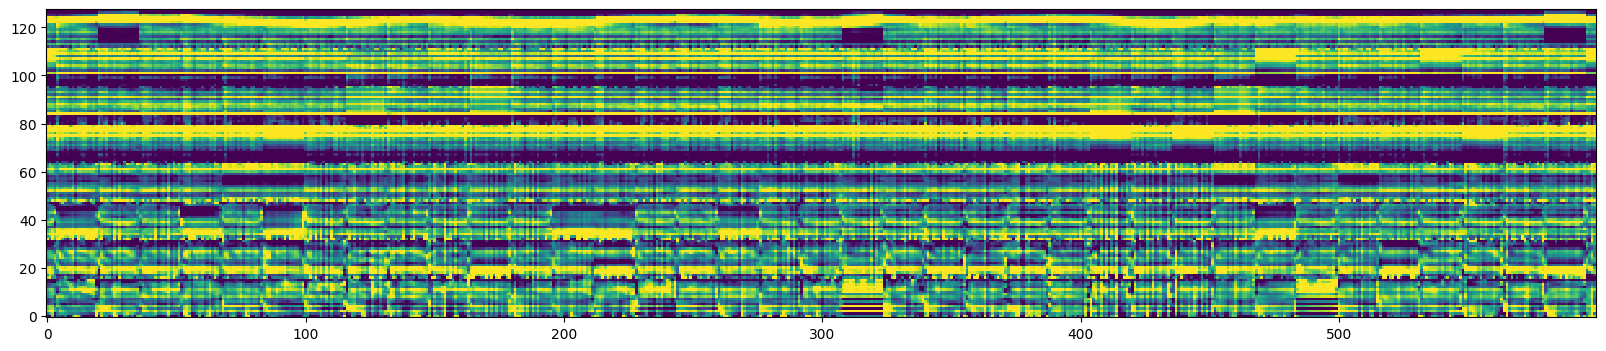

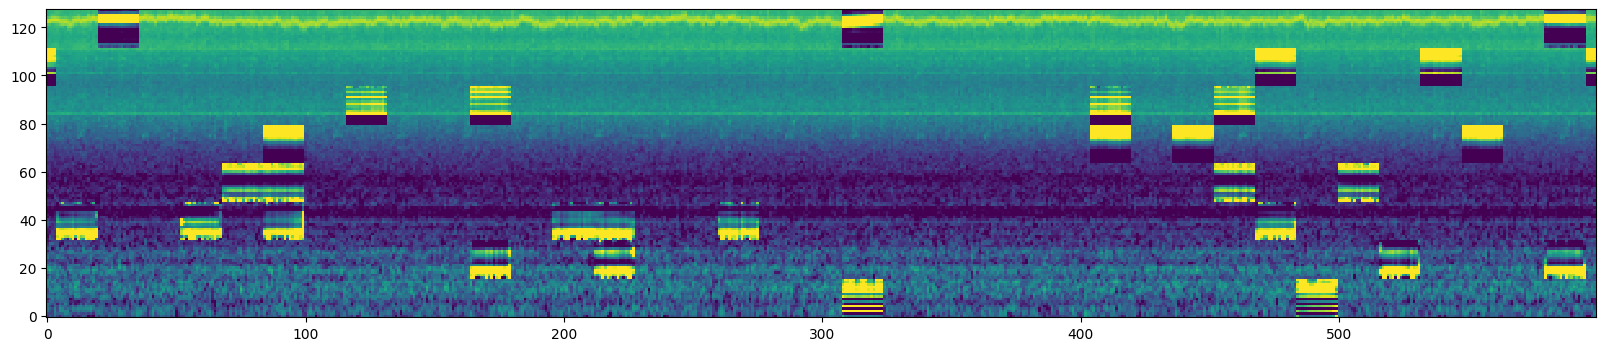

In [64]:
create_spec('/home/adelina/projectMae/multimodal-mae-main/audio_files/dvc-backboard@30.06.2023_14.12.53Z_30.06.2023_14.27.54Z@3d0025-MKP6yyqB6L89CwLeJL7AH8.wav')

Cage c4, 30 june

/tmp/ipykernel_561028/2852888603.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(fbank)


torch.Size([1, 512, 256])


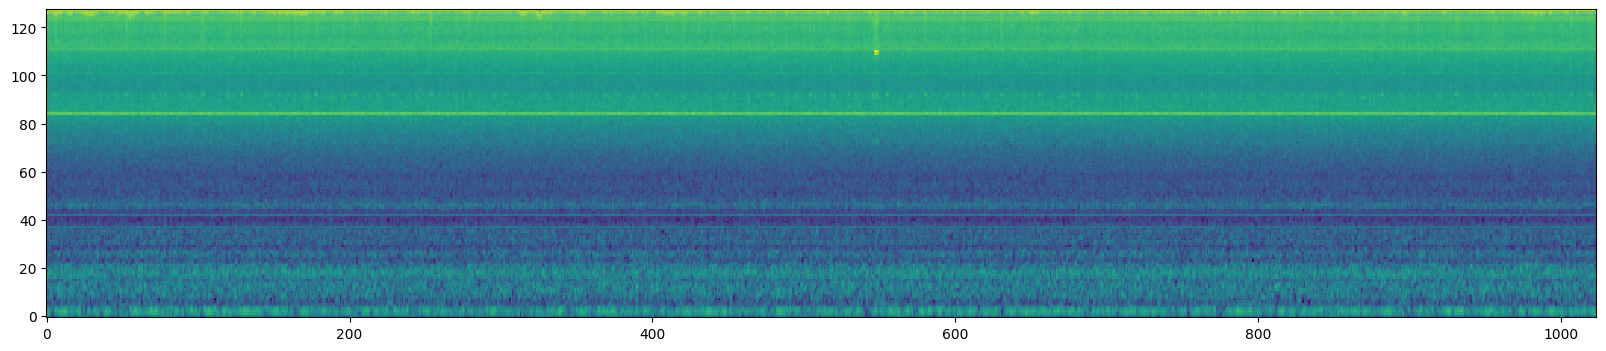

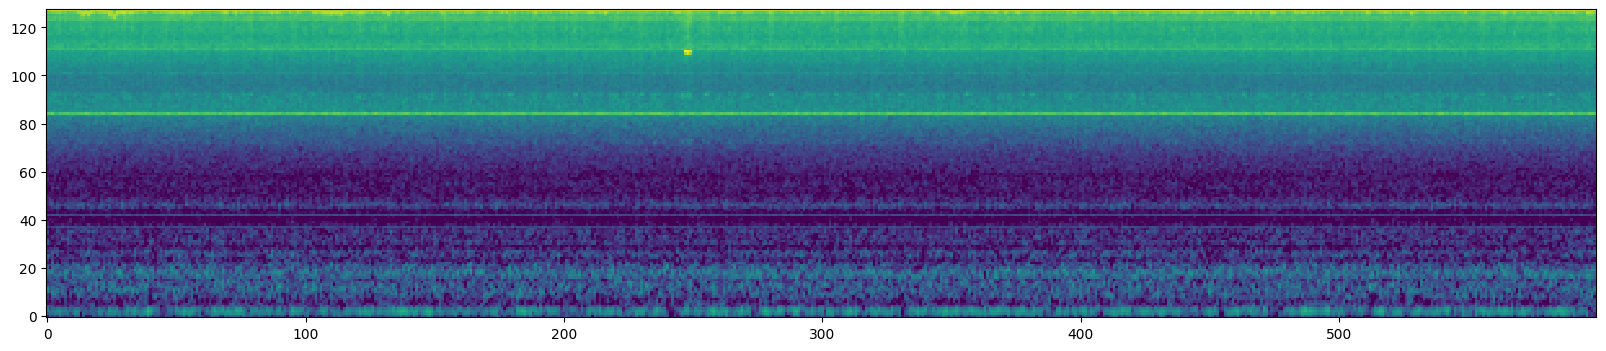

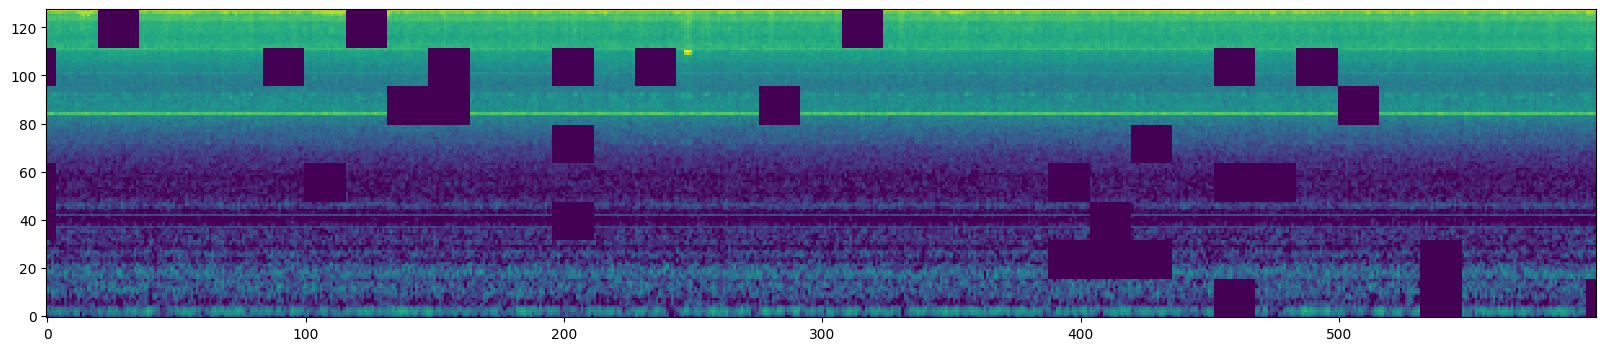

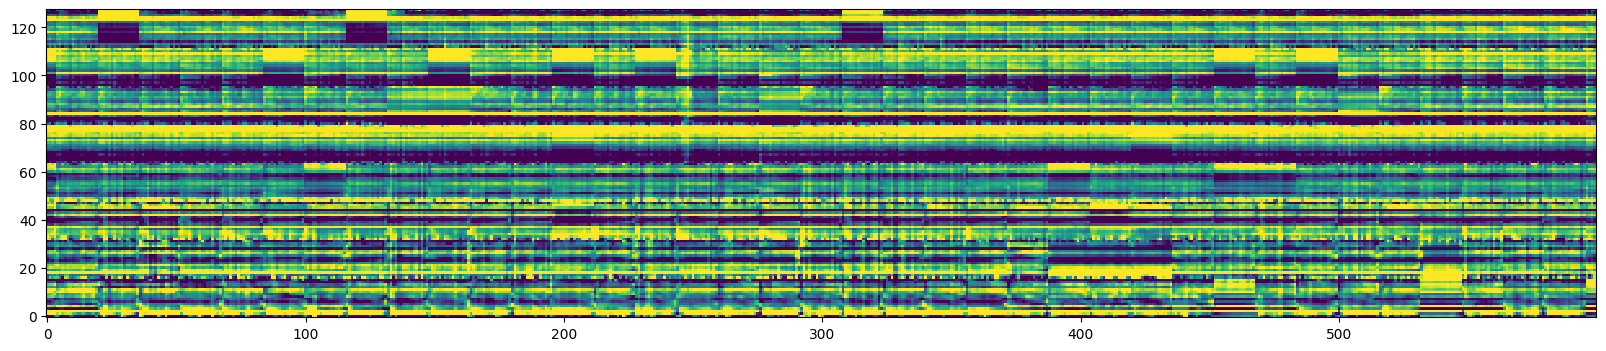

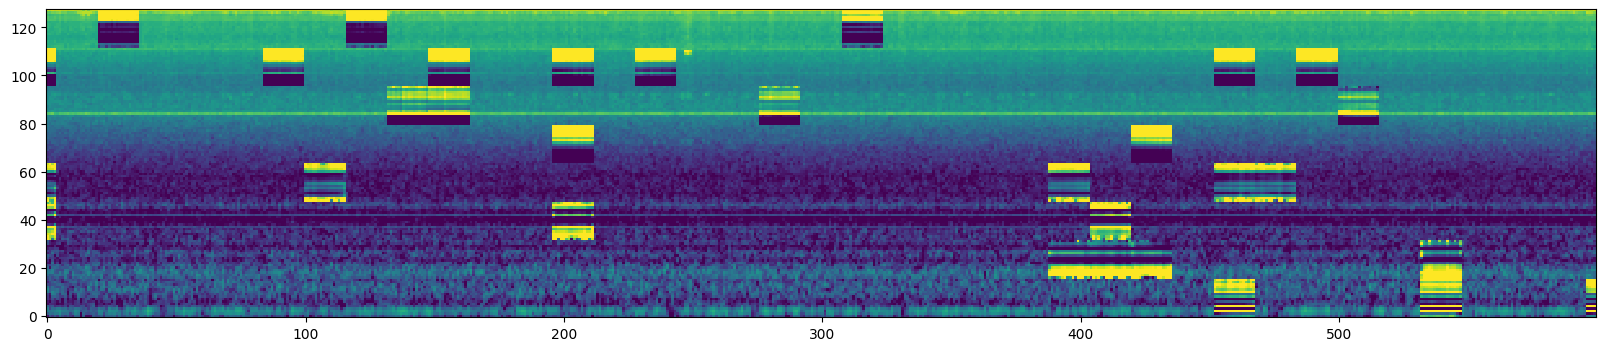

In [65]:
create_spec('/home/adelina/projectMae/multimodal-mae-main/audio_files/dvc-backboard@30.06.2023_11.12.46Z_30.06.2023_11.27.47Z@3d0023-LyoTrRGERABogUaUhxYAsW.wav')